# Разработка нейросети

## Импорт библиотек

In [3]:
from binance.client import Client
from binance.um_futures import UMFutures
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient
from binance.lib.utils import config_logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import keys
import time
import math
import random
from datetime import datetime
from pytz import timezone
import logging
import requests
import json
import re
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from math import ceil
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None # отключение  предупреждения
pd.set_option('display.max_columns', None) # показывать максимальное количесвто столбцов

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Загрузка локальных данных

In [5]:
df = pd.read_csv('ds_tot_5_step.csv')

In [6]:
df.head(2)

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std,target
0,0.21362,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0,0.937615,3061.0,19713.0,9,4,311.1,9662.5,0.0,9647.5,966.3,6624.4,-0.000900
1,0.21436,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0,-0.152753,27194.0,11165.0,7,7,7858.2,5775.6,5904.5,4357.0,7986.6,3538.8,-0.001675


In [7]:
df.shape

(78987, 33)

### Удаление признаков

In [8]:
df.columns

Index(['mid_price', 'ask_1', 'ask_2', 'ask_3', 'ask_4', 'ask_5', 'ask_6',
       'ask_7', 'ask_8', 'ask_9', 'ask_10', 'bid_1', 'bid_2', 'bid_3', 'bid_4',
       'bid_5', 'bid_6', 'bid_7', 'bid_8', 'bid_9', 'bid_10', 'imbalance_vol',
       'ask_max', 'bid_max', 'max_ask_level', 'max_bid_level', 'asks_mean',
       'bids_mean', 'asks_median', 'bids_median', 'asks_std', 'bids_std',
       'target'],
      dtype='object')

In [9]:
features = ['ask_1', 'ask_2', 'ask_3', 'ask_4', 'ask_5', 'ask_6',
       'ask_7', 'ask_8', 'ask_9', 'ask_10', 'bid_1', 'bid_2', 'bid_3', 'bid_4',
       'bid_5', 'bid_6', 'bid_7', 'bid_8', 'bid_9', 'bid_10', 'imbalance_vol',
       'ask_max', 'bid_max', 'max_ask_level', 'max_bid_level', 'asks_mean',
       'bids_mean', 'asks_median', 'bids_median', 'asks_std', 'bids_std',
       'target']

In [10]:
# df = df[features]

In [11]:
df.head(2)

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std,target
0,0.21362,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0,0.937615,3061.0,19713.0,9,4,311.1,9662.5,0.0,9647.5,966.3,6624.4,-0.000900
1,0.21436,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0,-0.152753,27194.0,11165.0,7,7,7858.2,5775.6,5904.5,4357.0,7986.6,3538.8,-0.001675


## ML

### Разделение дата-сета

In [12]:
train, test = train_test_split(df, test_size=0.25, random_state= 12)
print('Размерность train:', train.shape)
print('Размерность test:', test.shape)

Размерность train: (59240, 33)
Размерность test: (19747, 33)


In [13]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test.drop('target', axis=1)
y_test = test['target']
print('Размерность X_train:', X_train.shape)
print('Размерность y_train:', y_train.shape)
print('Размерность X_test:', X_test.shape)
print('Размерность y_test:', y_test.shape)

Размерность X_train: (59240, 32)
Размерность y_train: (59240,)
Размерность X_test: (19747, 32)
Размерность y_test: (19747,)


### Масштабирование признаков

In [14]:
num_features = X_train.columns 

In [15]:
scaler = StandardScaler()

In [16]:
scaler.fit(X_train[num_features]);

In [17]:
X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features]);

In [18]:
display(X_train.head(2))
display(X_test.head(2))

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
25797,-0.047546,-0.327209,-0.141186,0.020245,0.902380,0.880074,0.363050,-0.308424,-0.390156,-0.068205,-0.046103,-0.089958,-0.028373,0.131201,-0.058516,-0.060906,0.301169,0.140253,-0.212181,-0.194728,0.060619,-0.149046,-0.289173,-0.140335,-1.447689,0.941001,0.137972,-0.06382,0.698001,0.216748,-0.250561,-0.144761
75964,-0.853859,0.754582,2.319821,2.974580,0.700736,0.143903,-0.009501,0.464325,-0.026062,0.252949,4.252517,0.085997,0.481255,0.101103,0.220163,0.511059,0.194654,-0.362815,0.141266,0.174501,0.193866,-0.548116,2.153099,-0.081652,0.894243,0.941001,2.086992,0.36220,1.640075,1.087686,1.799474,-0.119591


,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
18403,1.316802,0.374929,0.098336,-0.220438,0.068645,-0.374177,0.181898,-0.002000,-0.734428,-0.451190,0.977776,-0.089958,-0.148755,-0.174866,-0.161049,-0.576753,-0.553979,-0.353055,-0.138785,-0.026641,1.873527,0.237147,0.186059,0.658091,0.894243,0.941001,-0.051264,0.229925,-0.258710,-0.720163,0.065539,0.622455
24596,0.083451,-0.397753,-0.474454,-0.500884,-0.666973,-0.723958,-0.871325,-0.826386,-0.869748,-0.811218,-0.569371,-0.089958,-0.477667,-0.174866,-0.249300,-0.766163,-0.867869,-0.864930,-0.277878,-0.298202,-0.269230,0.587729,-0.743266,-0.285605,0.894243,0.941001,-1.265650,-0.802254,-1.321867,-1.294813,-0.761172,-0.256256


### Dummy Regressor

Получим предсказания от константной модели 

In [19]:
Dummy_regressor = DummyRegressor(strategy='mean')

In [20]:
Dummy_regressor.fit(X_train, y_train)

DummyRegressor()

In [21]:
Dummy_regressor_predict = Dummy_regressor.predict(X_test)

In [22]:
MAE_Dummy_regressor = mean_absolute_error(y_test, Dummy_regressor_predict)

In [23]:
print('MAE константной модели:', round(MAE_Dummy_regressor, 5))

MAE константной модели: 0.00285


### Random Forest

In [24]:
RandomForest = RandomForestRegressor(random_state= 12)

In [25]:
param_RS_RandomForest={'max_depth':list(np.arange(2, 100, step=5)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [26]:
R_Search_RandomForest = RandomizedSearchCV(RandomForest, param_RS_RandomForest, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)

In [27]:
# %%time
# model_RF = R_Search_RandomForest.fit(X_train, y_train)
# print(model_RF.best_params_)
# print(model_RF.best_score_)

In [28]:
# MAE_RandomForest = model_RF.best_score_.round(5)

In [29]:
# print('MAE_RandomForest:', MAE_RandomForest)

MAE_RandomForest: -0.00268

### Catboost

In [30]:
CatBoost = CatBoostRegressor(random_state=12,
                              verbose=0,
                              cat_features = None)
                              #task_type = device_for_Catboost)

In [31]:
param_RS_CatBoost = {'depth':list(np.arange(1, 16, step=2)),
              'learning_rate':np.arange(0.01, 0.3, step=0.05),
              'n_estimators':np.arange(100, 1000, step=50),
              'l2_leaf_reg':np.arange(2, 30, step=1)
         }

In [32]:
R_Search_CatBoost = RandomizedSearchCV(CatBoost, param_RS_CatBoost, n_iter=5, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)

In [33]:
# %%time
# model_Cb = R_Search_CatBoost.fit(X_train, y_train)
# print(model_Cb.best_params_)
# print(model_Cb.best_score_)

In [34]:
# MAE_CatBoost = model_Cb.best_score_.round(5)

In [35]:
# print('MAE_CatBoost:', MAE_CatBoost)

MAE_CatBoost: -0.00268

### Net

#### Разделение датасета

In [36]:
train_net, df_50 = train_test_split(df, test_size=0.5, random_state= 12)
valid_net, test_net = train_test_split(df_50, test_size=0.5, random_state= 12)
print('Размерность train:', train_net.shape)
print('Размерность valid:', valid_net.shape)
print('Размерность test:', test_net.shape)

Размерность train: (39493, 33)
Размерность valid: (19747, 33)
Размерность test: (19747, 33)


In [37]:
X_train_net = train_net.drop('target', axis=1)
y_train_net = train_net['target']
X_valid_net = valid_net.drop('target', axis=1)
y_valid_net = valid_net['target']
X_test_net = test_net.drop('target', axis=1)
y_test_net = test_net['target']
print('Размерность X_train_net:', X_train_net.shape)
print('Размерность y_train_net:', y_train_net.shape)
print('Размерность X_valid_net:', X_valid_net.shape)
print('Размерность y_valid_net:', y_valid_net.shape)
print('Размерность X_test_net:', X_test_net.shape)
print('Размерность y_test_net:', y_test_net.shape)

Размерность X_train_net: (39493, 32)
Размерность y_train_net: (39493,)
Размерность X_valid_net: (19747, 32)
Размерность y_valid_net: (19747,)
Размерность X_test_net: (19747, 32)
Размерность y_test_net: (19747,)


#### Масштабирование признаков

In [38]:
scaler_net = StandardScaler()

In [39]:
scaler_net.fit(X_train_net[num_features]);

In [40]:
X_train_net[num_features] = scaler_net.transform(X_train_net[num_features])
X_valid_net[num_features] = scaler_net.transform(X_valid_net[num_features])
X_test_net[num_features] = scaler_net.transform(X_test_net[num_features]);

In [41]:
display(X_train_net.head(2))
display(X_valid_net.head(2))
display(X_test_net.head(2))

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
53174,-0.774928,-0.146457,0.152701,-0.318943,-0.613981,-0.490766,-0.678448,-0.171913,-0.193271,0.161263,0.209402,-0.323233,-0.489124,-0.146333,-0.634353,-0.748857,-0.871899,-0.708682,-0.276632,-0.799268,-0.292520,-1.332118,-0.274561,-0.352184,0.892764,0.939994,-0.341056,-0.907390,-0.663450,-1.296668,-0.185452,-0.337642
76748,-1.115874,-0.426598,0.060516,-0.249013,0.441795,0.404095,0.761782,1.023664,1.118156,2.067992,0.503710,-0.323233,-0.489124,0.082504,-0.277077,-0.200343,-0.120796,0.216836,-0.088403,0.135724,0.359261,-0.557592,0.692392,0.021523,0.425549,0.939994,1.316348,0.059777,1.787615,0.271641,0.736807,0.004615


,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
50051,-0.376488,0.642461,0.065929,0.842160,1.870425,0.908867,-0.270574,-0.408161,-0.428089,0.432069,4.876719,0.083035,-0.275603,-0.128894,-0.352413,-0.080443,1.051017,0.357409,0.067786,-0.169071,-0.222735,-0.734126,2.544566,-0.058308,0.892764,-0.900521,1.731646,-0.014090,0.551598,0.131166,2.336095,-0.043984
73530,-0.861525,-0.433465,-0.453001,-0.480279,-0.229578,-0.478584,-0.294687,0.037103,0.922753,-0.273471,-0.175826,0.385756,1.978724,0.239514,0.566364,1.421650,2.012310,0.931891,0.063368,0.543871,0.190954,0.806479,0.030523,0.129390,-0.041666,-0.900521,-0.198161,1.171179,-0.278505,2.270043,0.026610,0.000344


,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
78157,-1.095526,-0.433465,-0.340708,-0.491173,-0.066201,0.374017,-0.030345,0.072156,-0.433171,0.071853,0.216802,-0.323233,-0.489124,-0.057889,0.032600,-0.010701,-0.105647,-0.332041,0.306986,-0.566882,-0.084091,-0.095321,-0.270092,-0.054386,0.892764,0.019737,-0.103954,-0.169783,0.244403,0.017782,-0.182921,-0.078666
17834,1.329658,-0.433465,-0.486411,-0.491173,-0.628295,-0.735339,-0.864464,-0.820037,-0.638614,-0.738953,-0.716200,0.037682,0.848766,0.260838,-0.055369,0.431630,0.365120,0.063064,-0.118248,0.046340,0.069356,1.550674,-0.833639,-0.144698,0.892764,0.939994,-1.220551,0.276459,-1.297788,1.155999,-0.810052,-0.189644


#### Тензоры

In [42]:
X_train_tz = torch.FloatTensor(X_train_net.values).to(device)
y_train_tz = torch.FloatTensor(y_train_net.values).to(device)
X_valid_tz = torch.FloatTensor(X_valid_net.values).to(device)
y_valid_tz = torch.FloatTensor(y_valid_net.values).to(device)
X_test_tz = torch.FloatTensor(X_test_net.values).to(device)
y_test_tz = torch.FloatTensor(y_test_net.values).to(device)

In [43]:
print('Расмерность X_train_tz:', X_train_tz.shape)
print('Расмерность y_train_tz:', y_train_tz.shape)
print('Расмерность X_valid_tz:', X_valid_tz.shape)
print('Расмерность y_valid_tz:', y_valid_tz.shape)
print('Расмерность X_test_tz:', X_test_tz.shape)
print('Расмерность y_test_tz:', y_test_tz.shape)

Расмерность X_train_tz: torch.Size([39493, 32])
Расмерность y_train_tz: torch.Size([39493])
Расмерность X_valid_tz: torch.Size([19747, 32])
Расмерность y_valid_tz: torch.Size([19747])
Расмерность X_test_tz: torch.Size([19747, 32])
Расмерность y_test_tz: torch.Size([19747])


#### Кол-во нейронов входного и вых слоя

In [44]:
n_in_neurons, n_out_neurons = X_train_net.shape[1], 1 
print(n_in_neurons)
print(n_out_neurons)

32
1


#### Функция потерь

In [45]:
loss = nn.MSELoss()

#### Архитектура сети

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        #self.act1 = nn.ELU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
        #self.act2 = nn.ReLU()

        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.uniform_(self.fc1.bias, a=-3, b=0)
        
    def forward(self, x):
        x = self.fc1(x)
        #x = self.act1(x)

        x = self.fc2(x)
        # x = self.act2(x)
        
        return x   

In [47]:
loss_value_current = []
MAE_current = []
Net(X_train_net.shape[1], 300, n_out_neurons).to(device)
net = Net(X_train_net.shape[1], 300, n_out_neurons).to(device)

In [90]:
def run_net(model, num_epochs, learning_rate):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    epoch = 0
    epoch_end = 0
    MAE = 0
    MAE_best = math.inf
    R_2_best = -100
    
    while True:
        if (epoch <= num_epochs): # and (MAE <= MAE_best):
            epoch += 1
            optimizer.zero_grad()
            preds = model.forward(X_train_tz).flatten().to(device)
            loss_value = loss(preds, y_train_tz)
            loss_value.backward()
            optimizer.step()
            if epoch % 10 == 0:
                model.eval()
                test_preds = model.forward(X_valid_tz).to(device)
                pred = test_preds.cpu().detach().numpy()
                MAE = mean_absolute_error(y_valid_net, pred)
                R_2 = r2_score(y_valid_net, pred)
                
                loss_value_current.append(loss_value.cpu().detach().numpy())
                MAE_current.append(MAE)
                
                if MAE < MAE_best:
                    MAE_best = MAE
                    epoch_end = epoch
                    R_2_best = R_2
        
                print('Функция потерь ===>', loss_value)
                print('MAE === > ', MAE)
                print('Эпоха === > ', epoch)
                print('R_2 === > ', R_2)
                print('------------------------------------------------------------------------------------')
        
        else:
            break
            
    return (
        print('MAE_best:', MAE_best),
        print('R_2_best:', R_2_best),
        print('Эпоха с лучшим MAE:', epoch_end)
    )

In [49]:
NUM_EPOCHS = 5000

In [50]:
loss_value_current = []
MAE_current = []
Net(n_in_neurons, 300, n_out_neurons).to(device)
net = Net(n_in_neurons, 300, n_out_neurons).to(device)
run_net(net, NUM_EPOCHS, 0.01)

MAE_best: 0.002833435751542333
R_2_best: 0.008083949976560145
Эпоха с лучшим MAE: 2190


(None, None, None)

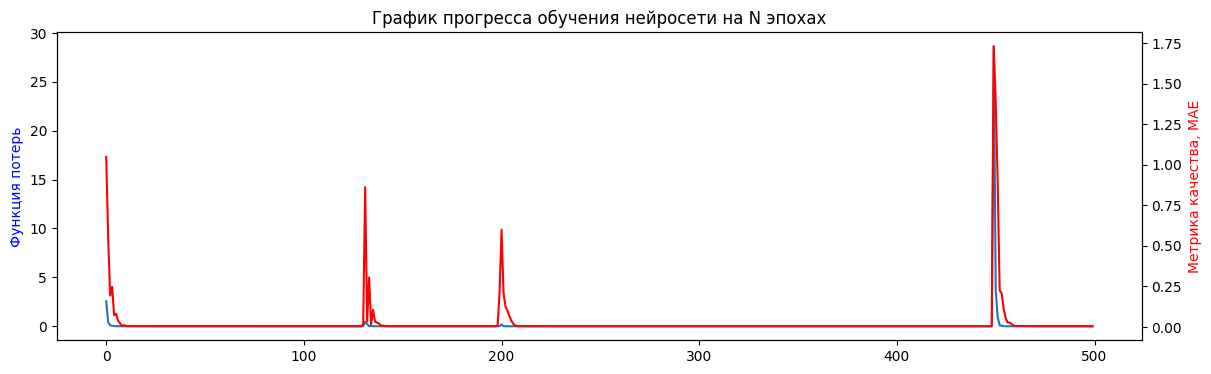

In [51]:
x1, y1 = list(range(len(loss_value_current))), loss_value_current # функция потерь
x2, y2 = list(range(len(MAE_current))), MAE_current             # метрика качества
fig, ax1 = plt.subplots(figsize = (14,4))
ax2 = ax1.twinx()
ax1.plot(x1, y1)
ax2.plot(x2, y2, color='red')
ax1.set_ylabel('Функция потерь', color='blue')
ax2.set_ylabel('Метрика качества, MAE', color='red')
plt.title('График прогресса обучения нейросети на N эпохах')
plt.xlabel('Эпохи, тыс')
plt.show();

Нейросеть обучается, но дает прогнозы соответствующие среднему значению целевого признака(R2 близко к 0). Попробуем увеличить качество предсказаний.

#### Подбор архитектуры сети

Подберём количество нейронов в скрытом слое:

In [52]:
num_neyrons =  [20,50,100,200,300,400,500,800,1000,1500,2000, 2500, 3000]  
learning_rate_list = np.arange(0.01, 0.1, step=0.01)             

In [ ]:
# for n_hidden_neurons_1 in num_neyrons:
#     learning_rate_ = random.choice(learning_rate_list)
#     Net(X_train.shape[1], n_hidden_neurons_1, 1).to(device)
#     net = Net(X_train.shape[1], n_hidden_neurons_1, 1).to(device)
#     print(f'При кол-ве нейронов в скрытом слое: { n_hidden_neurons_1}, learning_rate: {learning_rate_}')
#     run_net(net, 3000, learning_rate_)
#     print('--------------------------------------------------------------------------------')

При кол-ве нейронов в скрытом слое: 20, learning_rate: 0.09
MAE_best: 0.002828502174334575
R_2_best: 0.00476499543790232
Эпоха с лучшим MAE: 570
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 50, learning_rate: 0.08
MAE_best: 0.002833736860092697
R_2_best: 0.007887370060242649
Эпоха с лучшим MAE: 2380
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 100, learning_rate: 0.09
MAE_best: 0.002834112529644427
R_2_best: 0.007901240699321965
Эпоха с лучшим MAE: 3000
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 200, learning_rate: 0.01
MAE_best: 0.0028336440706949457
R_2_best: 0.008292120907238854
Эпоха с лучшим MAE: 2330
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 300, learning_rate: 0.05
MAE_best: 0.00283554277205

Увеличение количества нейронов в скрытом слое не улучшило метрики.

Создадим сеть с большим количеством скрытых слоев

In [101]:
n_neurons = [n_in_neurons, 50, 100, 200, 100, 50, n_out_neurons]
net_layers = []

In [102]:
for i in range(1, len(n_neurons)):
		net_layers.append(nn.Linear(n_neurons[i-1], n_neurons[i]))
		net_layers.append(nn.BatchNorm1d(n_neurons[i]))
		net_layers.append(nn.Dropout(random.choice(np.arange(0.1, 0.5, step=0.1))))

		# if (i+1) % 2 == 0:
		# 		net_layers.append(nn.ELU()) # функция активации для чётных слоёв
		# else:
		# 	net_layers.append(nn.Dropout(random.choice(np.arange(0.1, 0.5, step=0.1)))) # Dropout для нечетных		

In [103]:
net_2 = nn.Sequential(*net_layers).to(device)

In [104]:
print(net_2)

Sequential(
  (0): Linear(in_features=32, out_features=50, bias=True)
  (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=50, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=100, out_features=200, bias=True)
  (7): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=200, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.30000000000000004, inplace=False)
  (12): Linear(in_features=100, out_features=50, bias=True)
  (13): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.30000000000000004, inplace=False)
  (15): Linear(in_features=50, o

In [105]:
run_net(net_2, NUM_EPOCHS, 0.01)

Функция потерь ===> tensor(1.9104, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  1.0600239942235665
Эпоха === >  10
R_2 === >  -207228.4595400108
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.1490, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.16099567846946178
Эпоха === >  20
R_2 === >  -4068.083956822837
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.07142158559886096
Эпоха === >  30
R_2 === >  -2030.7796149292606
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.020910810057216823
Эпоха === >  40
R_2 === >  -115.58909767180631
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0

(None, None, None)

In [106]:
net.eval()
test_Net = net_2.forward(X_test_tz).to(device)
pred_net = test_Net.cpu().detach().numpy()
MAE_Net = mean_absolute_error(y_test_net, pred_net)

In [107]:
MAE_Net

0.002853291775244128